# 3D ResNet

Basic + Augmentations (invert, rotate, shear, blur, noise) + Batch Norm + Dropout (2/3) + l2

In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../..')

import datetime
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

import numpy as np

from src.data import train_test_split, MRISequence
from src.model import create_model, compile_model, load_checkpoint
from src.model.training import train
from src.model.evaluation import plot_training_history, show_simple_metrics, show_metrics

In [2]:
import tensorflow as tf

RANDOM_SEED = 300785674475887
tf.random.set_seed(RANDOM_SEED)

print(tf.version.VERSION)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

2.3.1
Num GPUs Available:  1


## Setup

In [3]:
%%time

ROOT_DIR = '../../tmp'
DEFAULT_CHECKPOINT_DIRECTORY_LOCAL = os.path.join(ROOT_DIR, 'checkpoints')
DEFAULT_BCKP_CHECKPOINT_DIRECTORY_LOCAL = os.path.join(ROOT_DIR, 'bckp-checkpoints')

LOG_DIRECTORY = os.path.join(ROOT_DIR, 'logs')
CHECKPOINT_DIRECTORY = DEFAULT_CHECKPOINT_DIRECTORY_LOCAL

LOG_DIRECTORY_LOCAL = LOG_DIRECTORY
CHECKPOINT_DIRECTORY_LOCAL = CHECKPOINT_DIRECTORY

DATA_DIR_NAME = 'data-v3'
DATA_DIR = os.path.join(ROOT_DIR, DATA_DIR_NAME)

saliencies_and_segmentations_v2_path = os.path.join(ROOT_DIR, 'saliencies_and_segmentations_v2')

if not os.path.exists(CHECKPOINT_DIRECTORY):
    os.mkdir(CHECKPOINT_DIRECTORY)

if not os.path.exists(LOG_DIRECTORY):
    os.mkdir(LOG_DIRECTORY)

val = False
    
class_names = ['AD', 'CN']

# get paths to data
train_dir, test_dir, val_dir = train_test_split(
    saliencies_and_segmentations_v2_path, 
    ROOT_DIR, 
    split=(0.8, 0.15, 0.05), 
    dirname=DATA_DIR_NAME)

# set the batch size for mri seq
batch_size = 12
input_shape = (104, 128, 104, 1) # (112, 112, 105, 1)
resize_img = True
crop_img = True

# if y is one-hot encoded or just scalar number
one_hot = True

# class weights (see analysis notebook)
class_weights = {0: 0.8072289156626505, 1: 1.3137254901960784}

# description statistics of the dataset
desc = {'mean': -3.6344006e-09, 'std': 1.0000092, 'min': -1.4982183, 'max': 10.744175}

if 'desc' not in locals():
    print('initializing desc...')
    desc = get_description(MRISequence(
        train_dir,
        64,
        class_names=class_names,
        input_shape=input_shape),
        max_samples=None)
    print(desc)


normalization={ 'type':'normalization', 'desc': desc }
# normalization={'type':'standardization', 'desc':desc }

augmentations = None
augmentations_inplace = True
# enable augmentations in mri seq (otherwise it can be enabled in dataset)
# augmentations={ 'random_swap_hemispheres': 0.5 }

# initialize sequences
print('initializing train_seq...')
train_seq = MRISequence(
    train_dir,
    batch_size,
    class_names=class_names,
    augmentations=augmentations,
    augmentations_inplace=augmentations_inplace,
    input_shape=input_shape,
    resize_img=resize_img,
    crop_img=crop_img,
    one_hot=one_hot,
    class_weights=class_weights,
    normalization=normalization)

print('initializing test_seq...')
test_seq = MRISequence(
    test_dir,
    batch_size,
    class_names=class_names,
    input_shape=input_shape,
    resize_img=resize_img,
    crop_img=crop_img,
    one_hot=one_hot,
    normalization=normalization)

if val:
    print('initializing val_seq...')
    val_seq = MRISequence(
        val_dir,
        batch_size,
        class_names=class_names,
        input_shape=input_shape,
        resize_img=resize_img,
        crop_img=crop_img,
        one_hot=one_hot,
        class_weights=class_weights,
        normalization=normalization)
else:
    print('val_seq = test_seq')
    val_seq = test_seq
    
model_key = datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
log_dir = os.path.join(LOG_DIRECTORY, model_key)
print(f'log_dir: {log_dir}')

not copying files since the destination directory already exists
initializing train_seq...
initializing test_seq...
val_seq = test_seq
log_dir: ../../tmp\logs\20210311-100331
Wall time: 0 ns


In [4]:
# https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#class_weights
# pos / neg
initial_bias = np.log([159/243, 243/159])

model_type = 'ResNet18'
model_config = {
    'input_shape': input_shape,
    'class_names': class_names,
    'l2_beta': 0.1,
#     'l2_beta': 0.0005,
#     'l2_beta': None,
    'dropout': 2 / 3,
#     'dropout': None,
    'output_bias': initial_bias,
    'batch_norm': True,
#     'output_bias': None,
    # https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization
}

compile_config = {
    # default is 0.001
#     'learning_rate': 0.000075,
    'learning_rate': 0.00005,
    'decay_steps': 25,
    'decay_rate': 0.96,
#     'beta_1': 0.85,
    'beta_1': 0.90,
#     'beta_2': 0.990,
    'beta_2': 0.999,
}

train_config = {
    'model_key': model_key,
    'epochs': 175,
    'patience': 50,
    'tensorboard_update_freq': 'epoch',
    'mri_tensorboard_callback': False,
    'model_checkpoint_callback': {'monitor': 'val_auc', 'mode': 'max', 'save_best_only': True},
    'early_stopping_monitor': {'monitor': 'val_auc', 'mode': 'max'},
    'augmentations': {
        'invert': (0.5, None),
        'rotate': (0.2, 5), # probability, degrees
        'zoom': (0., 0.),
        'shear': (0.2, 0.5), # probability, degrees
        'blur': (0.2, 0.85),
        'noise': (0.2, 0.00020)
    },
#     'augmentations': False,
    'batch_size': 10,
#     'model_checkpoint_callback': False,
}

## Train

In [5]:
model = create_model(model_type, model_config)
model, *_ = compile_model(model, **compile_config)
model.build(input_shape=input_shape)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 104, 128, 104)     0         
_________________________________________________________________
my_res_net (MyResNet)        (None, 512)               11770304  
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0

In [6]:
# load_checkpoint(model, DEFAULT_CHECKPOINT_DIRECTORY_LOCAL, '20201229-140515', 'cp-0001.ckpt')

In [7]:
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

print(get_available_gpus())

['/device:GPU:0']


In [8]:
%%time

model, checkpoint_dir, history = train(
    model,
    train_seq,
    test_seq,
    CHECKPOINT_DIRECTORY,
    LOG_DIRECTORY,
    DATA_DIR,
    **train_config
)

model key: 20210311-100331
checkpoint dir: ../../tmp\checkpoints\20210311-100331
log dir: ../../tmp\logs\20210311-100331
loading ../../tmp\data-v3\train_x.npy, ../../tmp\data-v3\train_y.npy...
loading ../../tmp\data-v3\val_x.npy, ../../tmp\data-v3\val_y.npy...
training...
Epoch 1/175
41/41 [==============================] - ETA: 0s - loss: 460.8803 - recall: 0.4950 - precision: 0.4950 - auc: 0.4885 - categorical_accuracy: 0.4950
Epoch 00001: val_auc improved from -inf to 0.41970, saving model to ../../tmp\checkpoints\20210311-100331\cp-0001.ckpt
41/41 [==============================] - 7s 177ms/step - loss: 460.8803 - recall: 0.4950 - precision: 0.4950 - auc: 0.4885 - categorical_accuracy: 0.4950 - val_loss: 446.7067 - val_recall: 0.3800 - val_precision: 0.3800 - val_auc: 0.4197 - val_categorical_accuracy: 0.3800
Epoch 2/175
41/41 [==============================] - ETA: 0s - loss: 436.0441 - recall: 0.5274 - precision: 0.5274 - auc: 0.5152 - categorical_accuracy: 0.5274
Epoch 00002: va

41/41 [==============================] - ETA: 0s - loss: 269.8789 - recall: 0.5100 - precision: 0.5100 - auc: 0.5063 - categorical_accuracy: 0.5100
Epoch 00016: val_auc did not improve from 0.46230
41/41 [==============================] - 6s 140ms/step - loss: 269.8789 - recall: 0.5100 - precision: 0.5100 - auc: 0.5063 - categorical_accuracy: 0.5100 - val_loss: 266.8373 - val_recall: 0.3900 - val_precision: 0.3900 - val_auc: 0.4522 - val_categorical_accuracy: 0.3900
Epoch 17/175
41/41 [==============================] - ETA: 0s - loss: 264.3324 - recall: 0.5249 - precision: 0.5249 - auc: 0.5354 - categorical_accuracy: 0.5249- ETA: 2s - loss: 265.4783 - recall: 0.5227 - precision: 0.5227 - auc: 0.5382 - categorical_
Epoch 00017: val_auc did not improve from 0.46230
41/41 [==============================] - 6s 144ms/step - loss: 264.3324 - recall: 0.5249 - precision: 0.5249 - auc: 0.5354 - categorical_accuracy: 0.5249 - val_loss: 261.5328 - val_recall: 0.3900 - val_precision: 0.3900 - val_

Epoch 32/175
41/41 [==============================] - ETA: 0s - loss: 216.9012 - recall: 0.6393 - precision: 0.6393 - auc: 0.6752 - categorical_accuracy: 0.6393- ETA: 4s - loss: 217.5834 - recall: 0.6167 - precision: 0.6167 - auc: 0.6833 - cat - ETA: 1s - loss: 217.0919 - recall: 0.6484 - precision: 0.6484 - auc: 0.6798 - categorical_accuracy
Epoch 00032: val_auc did not improve from 0.55450
41/41 [==============================] - 6s 153ms/step - loss: 216.9012 - recall: 0.6393 - precision: 0.6393 - auc: 0.6752 - categorical_accuracy: 0.6393 - val_loss: 216.0627 - val_recall: 0.3900 - val_precision: 0.3900 - val_auc: 0.4638 - val_categorical_accuracy: 0.3900
Epoch 33/175
41/41 [==============================] - ETA: 0s - loss: 215.1915 - recall: 0.6468 - precision: 0.6468 - auc: 0.7002 - categorical_accuracy: 0.6468
Epoch 00033: val_auc did not improve from 0.55450
41/41 [==============================] - 7s 167ms/step - loss: 215.1915 - recall: 0.6468 - precision: 0.6468 - auc: 0.700

Epoch 48/175
41/41 [==============================] - ETA: 0s - loss: 199.9100 - recall: 0.7114 - precision: 0.7114 - auc: 0.7808 - categorical_accuracy: 0.7114
Epoch 00048: val_auc did not improve from 0.66520
41/41 [==============================] - 7s 161ms/step - loss: 199.9100 - recall: 0.7114 - precision: 0.7114 - auc: 0.7808 - categorical_accuracy: 0.7114 - val_loss: 199.7058 - val_recall: 0.6000 - val_precision: 0.6000 - val_auc: 0.6438 - val_categorical_accuracy: 0.6000
Epoch 49/175
41/41 [==============================] - ETA: 0s - loss: 199.3004 - recall: 0.7363 - precision: 0.7363 - auc: 0.8280 - categorical_accuracy: 0.7363
Epoch 00049: val_auc improved from 0.66520 to 0.68180, saving model to ../../tmp\checkpoints\20210311-100331\cp-0049.ckpt
41/41 [==============================] - 6s 156ms/step - loss: 199.3004 - recall: 0.7363 - precision: 0.7363 - auc: 0.8280 - categorical_accuracy: 0.7363 - val_loss: 199.1503 - val_recall: 0.6700 - val_precision: 0.6700 - val_auc: 0.

Epoch 64/175
40/41 [============================>.] - ETA: 0s - loss: 194.0218 - recall: 0.7625 - precision: 0.7625 - auc: 0.8545 - categorical_accuracy: 0.7625
Epoch 00064: val_auc did not improve from 0.69620
41/41 [==============================] - 5s 131ms/step - loss: 194.0197 - recall: 0.7637 - precision: 0.7637 - auc: 0.8558 - categorical_accuracy: 0.7637 - val_loss: 194.0981 - val_recall: 0.6100 - val_precision: 0.6100 - val_auc: 0.6601 - val_categorical_accuracy: 0.6100
Epoch 65/175
40/41 [============================>.] - ETA: 0s - loss: 193.7910 - recall: 0.7950 - precision: 0.7950 - auc: 0.8793 - categorical_accuracy: 0.7950
Epoch 00065: val_auc did not improve from 0.69620
41/41 [==============================] - 7s 167ms/step - loss: 193.7927 - recall: 0.7910 - precision: 0.7910 - auc: 0.8765 - categorical_accuracy: 0.7910 - val_loss: 193.9031 - val_recall: 0.6000 - val_precision: 0.6000 - val_auc: 0.6592 - val_categorical_accuracy: 0.6000
Epoch 66/175
41/41 [============

Epoch 81/175
40/41 [============================>.] - ETA: 0s - loss: 191.8360 - recall: 0.8200 - precision: 0.8200 - auc: 0.9021 - categorical_accuracy: 0.8200
Epoch 00081: val_auc did not improve from 0.69620
41/41 [==============================] - 7s 159ms/step - loss: 191.8346 - recall: 0.8209 - precision: 0.8209 - auc: 0.9031 - categorical_accuracy: 0.8209 - val_loss: 192.0317 - val_recall: 0.6700 - val_precision: 0.6700 - val_auc: 0.6921 - val_categorical_accuracy: 0.6700
Epoch 82/175
41/41 [==============================] - ETA: 0s - loss: 191.7975 - recall: 0.7960 - precision: 0.7960 - auc: 0.8780 - categorical_accuracy: 0.7960
Epoch 00082: val_auc did not improve from 0.69620
41/41 [==============================] - 6s 143ms/step - loss: 191.7975 - recall: 0.7960 - precision: 0.7960 - auc: 0.8780 - categorical_accuracy: 0.7960 - val_loss: 191.9685 - val_recall: 0.6800 - val_precision: 0.6800 - val_auc: 0.6922 - val_categorical_accuracy: 0.6800
Epoch 83/175
40/41 [============

Epoch 97/175
41/41 [==============================] - ETA: 0s - loss: 191.1756 - recall: 0.8085 - precision: 0.8085 - auc: 0.8884 - categorical_accuracy: 0.8085
Epoch 00097: val_auc did not improve from 0.70195
41/41 [==============================] - 6s 153ms/step - loss: 191.1756 - recall: 0.8085 - precision: 0.8085 - auc: 0.8884 - categorical_accuracy: 0.8085 - val_loss: 191.3736 - val_recall: 0.7000 - val_precision: 0.7000 - val_auc: 0.7018 - val_categorical_accuracy: 0.7000
Epoch 98/175
40/41 [============================>.] - ETA: 0s - loss: 191.1247 - recall: 0.8250 - precision: 0.8250 - auc: 0.9030 - categorical_accuracy: 0.8250
Epoch 00098: val_auc did not improve from 0.70195
41/41 [==============================] - 6s 143ms/step - loss: 191.1257 - recall: 0.8209 - precision: 0.8209 - auc: 0.9019 - categorical_accuracy: 0.8209 - val_loss: 191.3514 - val_recall: 0.7000 - val_precision: 0.7000 - val_auc: 0.7014 - val_categorical_accuracy: 0.7000
Epoch 99/175
40/41 [============

41/41 [==============================] - 7s 159ms/step - loss: 190.9525 - recall: 0.7935 - precision: 0.7935 - auc: 0.8762 - categorical_accuracy: 0.7935 - val_loss: 191.1441 - val_recall: 0.6900 - val_precision: 0.6900 - val_auc: 0.7030 - val_categorical_accuracy: 0.6900
Epoch 114/175
40/41 [============================>.] - ETA: 0s - loss: 190.9432 - recall: 0.8275 - precision: 0.8275 - auc: 0.8875 - categorical_accuracy: 0.8275
Epoch 00114: val_auc did not improve from 0.70295
41/41 [==============================] - 6s 147ms/step - loss: 190.9427 - recall: 0.8284 - precision: 0.8284 - auc: 0.8878 - categorical_accuracy: 0.8284 - val_loss: 191.1369 - val_recall: 0.6700 - val_precision: 0.6700 - val_auc: 0.7011 - val_categorical_accuracy: 0.6700
Epoch 115/175
40/41 [============================>.] - ETA: 0s - loss: 190.9520 - recall: 0.7850 - precision: 0.7850 - auc: 0.8673 - categorical_accuracy: 0.7850- ETA: 2s - loss: 190.9360 - recall: 0.7842 - precision: 0.7842 - auc: 0.8695 - c

Epoch 130/175
40/41 [============================>.] - ETA: 0s - loss: 190.8600 - recall: 0.7975 - precision: 0.7975 - auc: 0.8755 - categorical_accuracy: 0.7975
Epoch 00130: val_auc did not improve from 0.70360
41/41 [==============================] - 6s 153ms/step - loss: 190.8587 - recall: 0.7985 - precision: 0.7985 - auc: 0.8765 - categorical_accuracy: 0.7985 - val_loss: 191.0630 - val_recall: 0.6800 - val_precision: 0.6800 - val_auc: 0.7013 - val_categorical_accuracy: 0.6800
Epoch 131/175
39/41 [===========================>..] - ETA: 0s - loss: 190.8539 - recall: 0.7974 - precision: 0.7974 - auc: 0.8745 - categorical_accuracy: 0.7974
Epoch 00131: val_auc did not improve from 0.70360
41/41 [==============================] - 6s 151ms/step - loss: 190.8512 - recall: 0.8010 - precision: 0.8010 - auc: 0.8766 - categorical_accuracy: 0.8010 - val_loss: 191.0606 - val_recall: 0.6800 - val_precision: 0.6800 - val_auc: 0.7025 - val_categorical_accuracy: 0.6800
Epoch 132/175
40/41 [=========

40/41 [============================>.] - ETA: 0s - loss: 190.8605 - recall: 0.7925 - precision: 0.7925 - auc: 0.8634 - categorical_accuracy: 0.7925
Epoch 00146: val_auc did not improve from 0.70360
41/41 [==============================] - 6s 136ms/step - loss: 190.8608 - recall: 0.7935 - precision: 0.7935 - auc: 0.8629 - categorical_accuracy: 0.7935 - val_loss: 191.0377 - val_recall: 0.6700 - val_precision: 0.6700 - val_auc: 0.7004 - val_categorical_accuracy: 0.6700
Epoch 147/175
41/41 [==============================] - ETA: 0s - loss: 190.8265 - recall: 0.8010 - precision: 0.8010 - auc: 0.8861 - categorical_accuracy: 0.8010
Epoch 00147: val_auc did not improve from 0.70360
41/41 [==============================] - 6s 156ms/step - loss: 190.8265 - recall: 0.8010 - precision: 0.8010 - auc: 0.8861 - categorical_accuracy: 0.8010 - val_loss: 191.0370 - val_recall: 0.6700 - val_precision: 0.6700 - val_auc: 0.7012 - val_categorical_accuracy: 0.6700
Epoch 148/175
40/41 [=======================

40/41 [============================>.] - ETA: 0s - loss: 190.7925 - recall: 0.8300 - precision: 0.8300 - auc: 0.9103 - categorical_accuracy: 0.8300
Epoch 00162: val_auc did not improve from 0.70380
41/41 [==============================] - 6s 150ms/step - loss: 190.7935 - recall: 0.8284 - precision: 0.8284 - auc: 0.9084 - categorical_accuracy: 0.8284 - val_loss: 191.0319 - val_recall: 0.7000 - val_precision: 0.7000 - val_auc: 0.7038 - val_categorical_accuracy: 0.7000
Epoch 163/175
41/41 [==============================] - ETA: 0s - loss: 190.8176 - recall: 0.8035 - precision: 0.8035 - auc: 0.8903 - categorical_accuracy: 0.8035
Epoch 00163: val_auc did not improve from 0.70380
41/41 [==============================] - 7s 159ms/step - loss: 190.8176 - recall: 0.8035 - precision: 0.8035 - auc: 0.8903 - categorical_accuracy: 0.8035 - val_loss: 191.0317 - val_recall: 0.7000 - val_precision: 0.7000 - val_auc: 0.7021 - val_categorical_accuracy: 0.7000
Epoch 164/175
41/41 [=======================

## Evaluation

Wall time: 78.1 ms


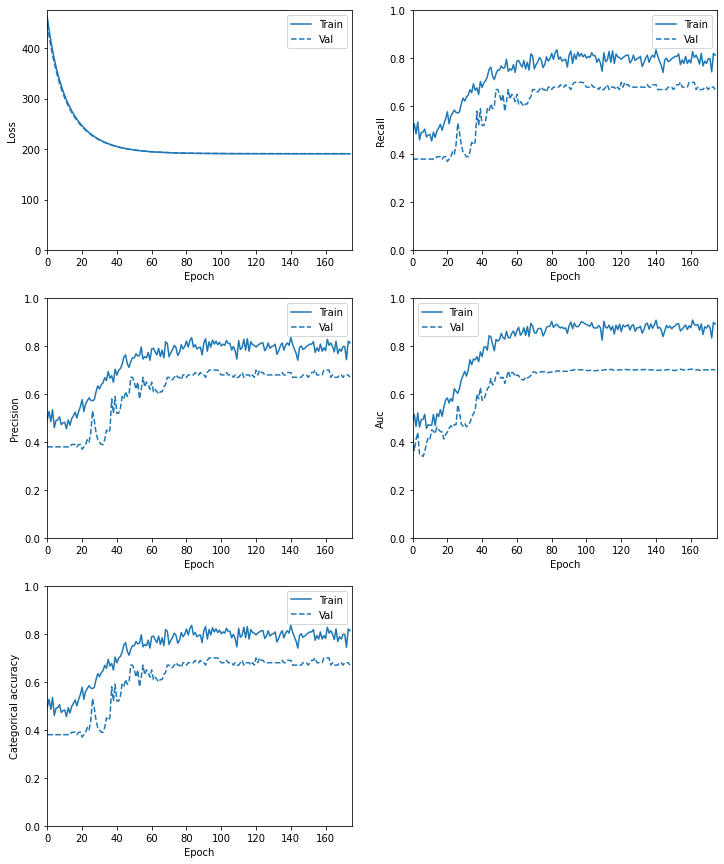

In [9]:
%%time

plot_training_history(history)

In [10]:
%%time

show_simple_metrics(model, test_seq)

loss: 191.02845764160156
recall: 0.6700000166893005
precision: 0.6700000166893005
auc: 0.700200080871582
categorical_accuracy: 0.6700000166893005

Wall time: 30.6 s


In binary classification, recall of the positive class is also known as “sensitivity”; recall of the negative class is “specificity”. (https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html)
AD
precision: 0.7735849056603774
recall: 0.6612903225806451
f1-score: 0.7130434782608696
support: 62


CN
precision: 0.5531914893617021
recall: 0.6842105263157895
f1-score: 0.611764705882353
support: 38


micro avg
precision: 0.67
recall: 0.67
f1-score: 0.67
support: 100


macro avg
precision: 0.6633881975110398
recall: 0.6727504244482173
f1-score: 0.6624040920716112
support: 100


weighted avg
precision: 0.6898354074668808
recall: 0.67
f1-score: 0.6745575447570333
support: 100


samples avg
precision: 0.67
recall: 0.67
f1-score: 0.67
support: 100


F1
micro: 0.67
macro: 0.6624040920716112


accuracy_score: 0.67
sensitivity_score: 0.6612903225806451
specificity_score: 0.6842105263157895


Wall time: 29 s


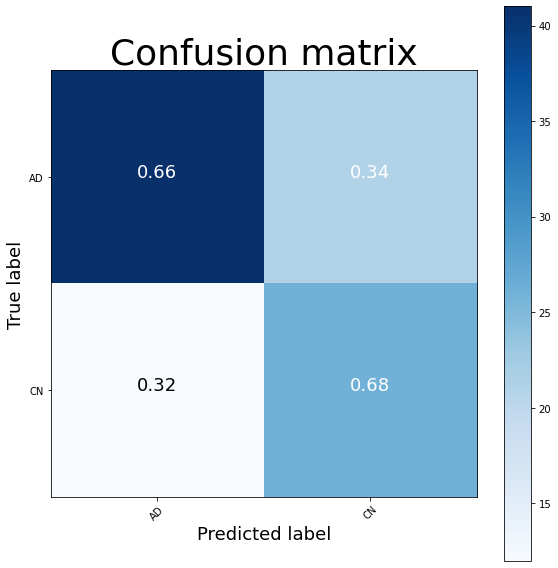

In [11]:
%%time

show_metrics(model, test_seq, class_names)